Tutorial 7: Masking and Positions
=================================

We've learnt nearly all the tools we need to model strong lenses, so I'm now going to quickly cover how you should
choose your mask. I'll also show you another neat trick to improve the speed and accuracy of your non-linear search.

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt
import autofit as af

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


we'll use the same strong lensing data as tutorials 1 & 2, where:

 - The lens galaxy's total mass distribution is a `SphericalIsothermal`.
 - The source galaxy's `LightProfile` is a `SphericalExponential`.

In [2]:
dataset_name = "mass_sis__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

When it comes to determining an appropriate mask for this image, the best approach is to set up a `Mask2D` and pass it 
to a `Imaging` mat_plot_2d. You can then check visually if the mask is an appropriate size or not. 

Below, we choose an inner radius that cuts into our lensed source galaxy - clearly this isn't a good mask.

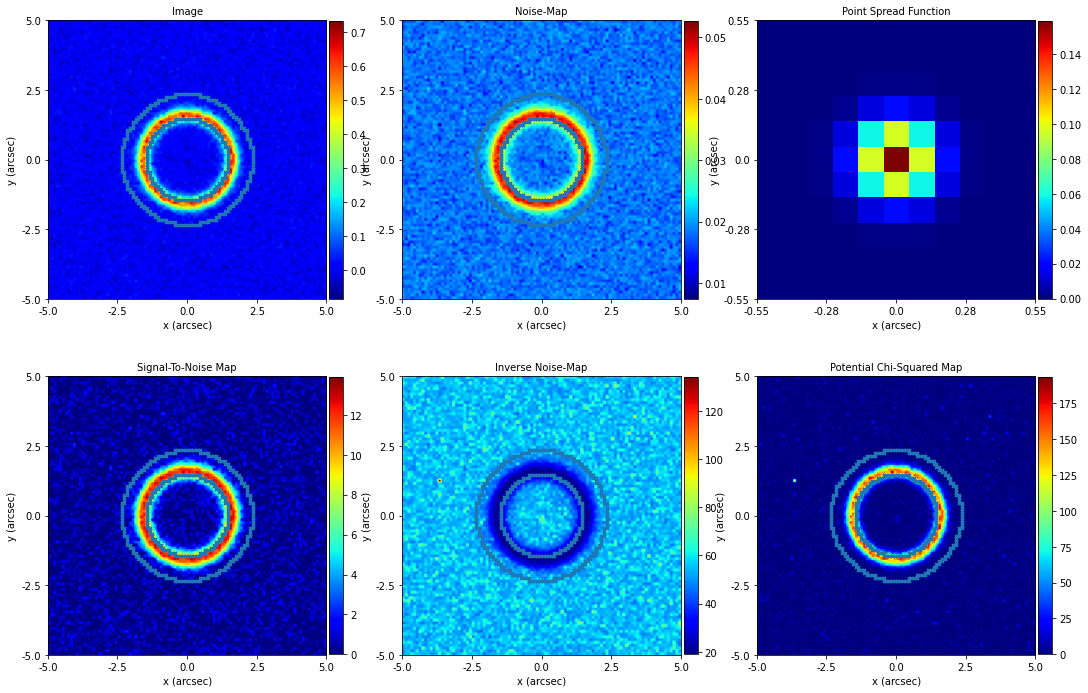

In [3]:
mask = al.Mask2D.circular_annular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    inner_radius=1.4,
    outer_radius=2.4,
)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

So, lets decrease the inner radius to correct for this.

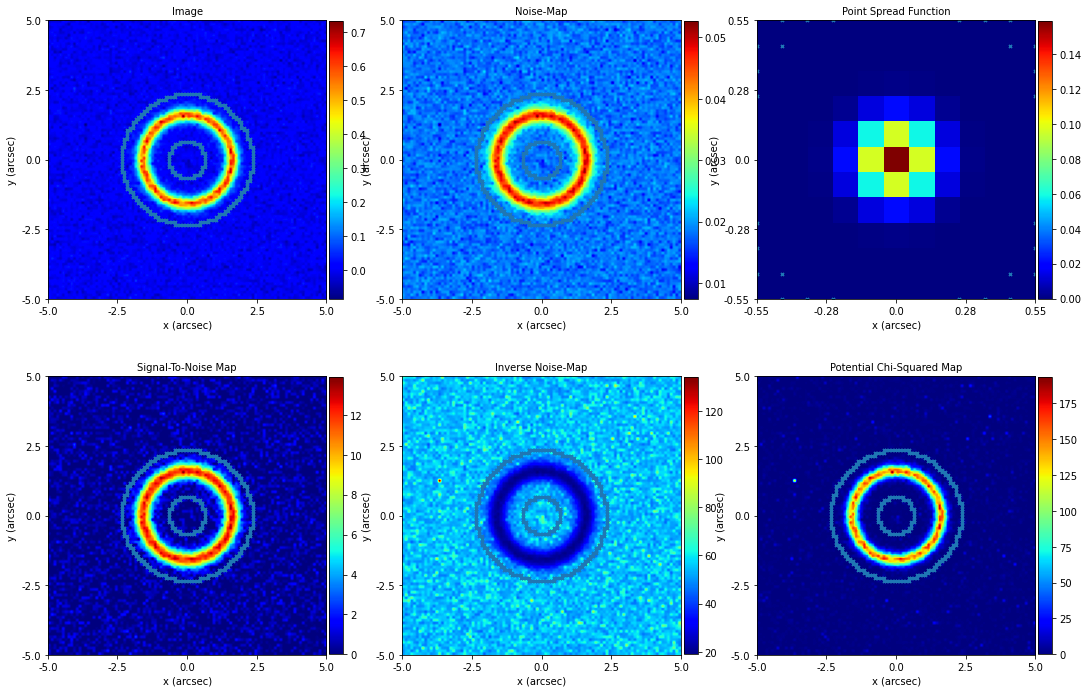

In [4]:
mask = al.Mask2D.circular_annular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    inner_radius=0.6,
    outer_radius=2.4,
)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

Like in the previous tutorial, we use a `SettingsPhaseImaging` object to specify our model-fitting procedure uses a 
regular `Grid2D`.

In [5]:
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D, sub_size=2)

settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

Now we create our phase as usual, remember that we pass the mask to the run function!

In [6]:
phase_with_custom_mask = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="howtolens", name="phase_t7_with_custom_mask", n_live_points=40
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(
        lens=al.GalaxyModel(redshift=0.5, mass=al.mp.SphericalIsothermal),
        source=al.GalaxyModel(redshift=1.0, bulge=al.lp.SphericalExponential),
    ),
)

phase_with_custom_mask.run(dataset=imaging, mask=mask)

INFO:root:phase_t7_with_custom_mask already completed, skipping non-linear search.


So, our mask encompasses the lensed source galaxy. However, is this really the right sized mask? Do we want a 
bigger mask? a smaller mask?

When it comes to masking, we are essentially balancing run-speed and accuracy. If speed wasn`t a consideration, 
bigger masks would *always* be better, for two reasons:

1) The lensed source galaxy may have very faint emission that when you look at the plot above you don't notice. 
 Overly aggressive masking risks you masking out some of that light, data which would better constrain your 
 lens model!
    
 2) When you fit an image with a model image the fit is performed only within the masked region. Outside of the 
 masked region it is possible that the model image produces some source-galaxy light in a region of the image 
 where it isn't actually observed. If this region is masked, the poor fit in this region won't reduce the model`s 
 log likelihood.

As you use **PyAutoLens** more you will get a feel for how fast an analysis will run given a certain image resolution, 
lens model complexity, `NonLinearSearch` priors / setup, etc. As you develop this intuition, I would recommend you 
always aim to use masks as big as possible which still give a reasonable run-speed. Aggressive masking will get your 
code running fast - but it could lead you to infer an incorrect lens model!

If you are fitting the foreground lens galaxy's light you pretty much have no choice but to use a large circular 
mask anyway, as you'll need to capture the lens's extended emission. Chances are this will encompass the entire 
source galaxy.

We can also manually specify a set of image-pixels correspondin to the multiple images of the source-galaxy(s). 
During the analysis, **PyAutoLens** will first check that these pixels trace within a specified arc-second threshold of 
one another (which is controlled by the `position_threshold` parameter input into a phase). This provides two benefits:

 1) The analysis runs faster as the `NonLinearSearch` avoids searching regions of parameter space where the 
 mass-model is clearly not accurate.
    
 2) By removing these solutions, a global-maximum solution may be reached instead of a local-maxima. This is 
 because removing the incorrect mass models makes the non-linear parameter space less complex.

We can easily check the image-positions are accurate by plotting them using our `ImagingPlotter`.(they are the magenta 
dots on the image).

To specify these positions, we use the `Grid2DIrregular` object, which is used by **PyAutoLens** in general to specify (y,x)
coordinates.

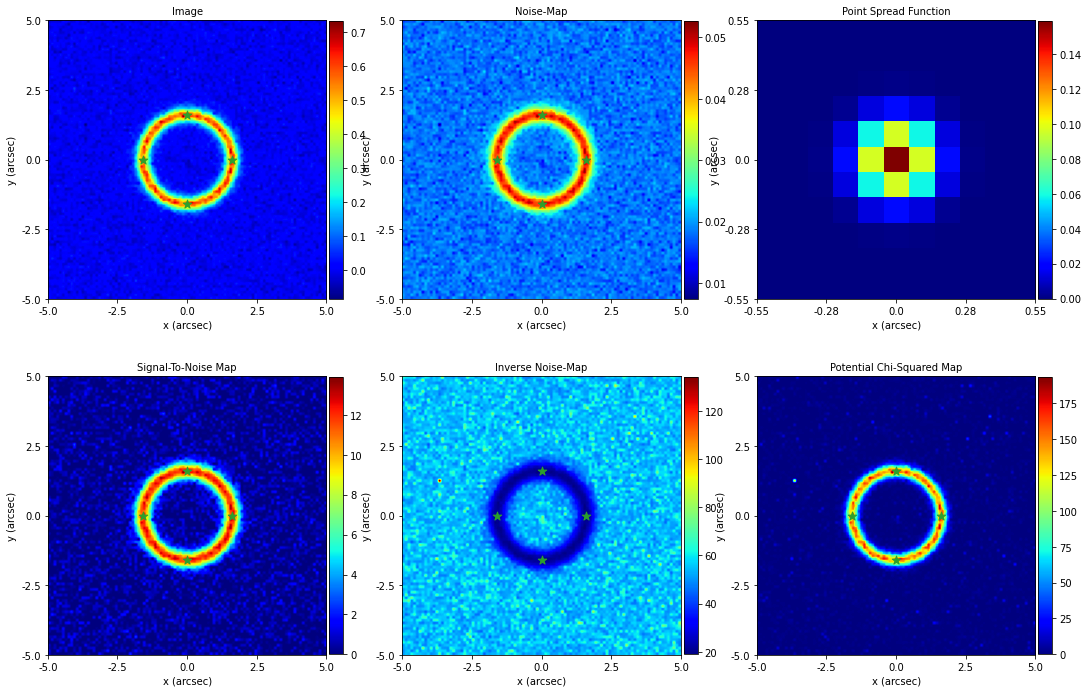

In [7]:
positions = al.Grid2DIrregular(grid=[(1.6, 0.0), (0.0, 1.6), (-1.6, 0.0), (0.0, -1.6)])

visuals_2d = aplt.Visuals2D(positions=positions)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, visuals_2d=visuals_2d)
imaging_plotter.subplot_imaging()

For the positions to be used in a Phase, we associate them with the `Imaging` data.
 
We also pass the `SettingsPhaseImaging` a new object, `SettingsLens`. This includes the *position_threshold* used 
during modeling to resample inaccurate mass models.

In [8]:
imaging = al.Imaging(
    image=imaging.image,
    noise_map=imaging.noise_map,
    psf=imaging.psf,
    positions=positions,
)

settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D, sub_size=2)
settings_lens = al.SettingsLens(positions_threshold=2.0)

settings = al.SettingsPhaseImaging(
    settings_masked_imaging=settings_masked_imaging, settings_lens=settings_lens
)

We can then tell our phase to use these positions in the analysis.

In [9]:
phase_with_positions = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="howtolens", name="phase_t7_with_positions", n_live_points=40
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(
        lens=al.GalaxyModel(redshift=0.5, mass=al.mp.SphericalIsothermal),
        source=al.GalaxyModel(redshift=1.0, bulge=al.lp.SphericalExponential),
    ),
)

print(
    "Dynesty has begun running - checkout the workspace/output/t7_with_positions"
    "  folder for live output of the results, images and lens model."
    "  This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

phase_with_positions.run(dataset=imaging, mask=mask)

print("Dynesty has finished run - you may now continue the notebook.")

INFO:root:phase_t7_with_positions already completed, skipping non-linear search.


Dynesty has begun running - checkout the workspace/output/t7_with_positions  folder for live output of the results, images and lens model.  This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!
Dynesty has finished run - you may now continue the notebook.


You may observe multiple source-galaxies each with their own set of multiple-images. If you have a means by which to 
pair different positions to the same source galaxies (for example, spectroscopic data) you can set up multiple sets of 
positions which each have to trace to within the position threshold of one another for the lens model to be accepted.

Lets load example data containing two distinct source galaxies.

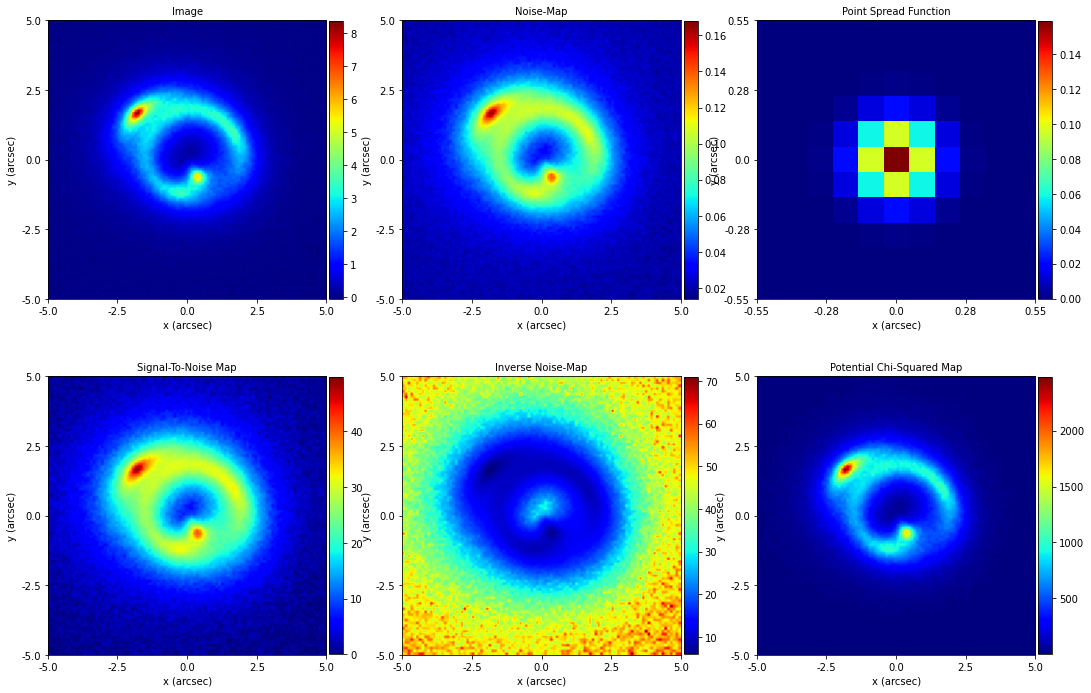

In [10]:
dataset_name = "mass_sie__source_sersic_x2"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

And that completes our final tutorial in this chapter! At this point, I recommend that you checkout the 
`autolens_workspace/notebooks/preprocess section of the workspace. This includes tools which allow you create custom masks and 
positions for a specific strong lens and output them so they can be loaded before an analysis.

When we cover pipelines next, you'll see that pipelines allow us to use a custom mask and set of positions for each 
lens we model. So, although we have to draw the masks and positions for each lens in a sample, once we've done that 
we can fit all lenses with one standardized pipeline!

There are two things you should bare in mind in terms of masking and positions:

 1) Customizing the mask and positions for the analysis of one strong lens gets the analysis running fast and can 
 provide accurate non-linear sampling. However, for a large sample of lenses, customizing the mask and positions 
 will begin to take a lot of time. If you're willing to put that time and effort in, great, but these solutions 
 *do not* scale-up to large samples of lenses.
    
 2) A word of warning - be *extremely* careful when using positions, especially if it is unclear if the lensed 
 source galaxy has one or multiple source's of light. If your position threshold is small and the positions you 
 give the analysis correspond to different parts of the source, you may remove the *correct lens model*. In my 
 experience, as long as you keep the threshold above ~0.5" you'll be fine.

And with that, we've completed the chapter.